In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from glob import glob
import pandas as pd
import pickle
import random
from PIL import Image
from glob import glob
import re
#from adjustText import adjust_text
import seaborn as sns
import statannot
import argparse
#import torch
import wandb
import sys
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.dataset import MRIDataset_Imgs, load_datasets, LabelConverter



In [3]:
def read_tag_from_wandb(tag, project_name, min_epoch_cutoff = 4):
    # read yolov7 runs
    api = wandb.Api()
    
    # Project is specified by <entity/project-name>
    runs = api.runs(path =f"nair-karthik00/{project_name}", filters = {'tags': tag})
    #runs.append(api.run('nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox/a935xpc7'))

    summary_list, config_list, name_list, history_list = [], [], [], []
    id_seen = {}
    for run in runs:
        name = run.name
        #if not re.match(pattern, name):
        #    continue
        if run.id in id_seen.keys(): # sometimes wandb passes in the same run twice, so safeguard against this
            continue
        else:
            id_seen[run.id] = True
        
        
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        dicto = run.summary._json_dict
        if 'val_dice_scores/class_Unknown' not in dicto.keys() or dicto['epoch'] < min_epoch_cutoff: # this run is not finished yet
            print('skip ' + name.split('_')[0].split('label')[1])
            continue
        summary_list.append(dicto)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)
        history_list.append(run.scan_history())

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })
    
    runs_df['label'] = [int(x.split('_')[0].split('label')[1]) for x in runs_df['name']]
    runs_df['subset'] = [float(x.split('_')[3]) for x in runs_df['name']]
    runs_df['batch_size'] = [int(x['batch_size']) for x in runs_df['config']]

    runs_df['val_dice_score'] = [x['val_dice_scores/class_Unknown']['max'] for x in runs_df['summary']]
    runs_df['num_samples_per_epoch'] = [x['num_training_samples'] / (x['epoch']+1) for x in runs_df['summary']]
    runs_df['num_samples_per_epoch'] = runs_df['num_samples_per_epoch'].astype(int)
    #runs_df = runs_df.sort_values('label').reset_index(drop=True)
    ret_df = runs_df[['label', 'name', 'subset', 'batch_size', 'val_dice_score', 'num_samples_per_epoch']]

    #assert ret_df.shape[0] == 102
    #assert ret_df['label'].value_counts().max() == 1
    
    return ret_df, history_list, name_list

def read_tag_from_wandb_unet(tag, project_name, min_epoch_cutoff = 4):
    # read yolov7 runs
    api = wandb.Api()
    
    # Project is specified by <entity/project-name>
    runs = api.runs(path =f"nair-karthik00/{project_name}", filters = {'tags': tag})
    #runs.append(api.run('nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox/a935xpc7'))

    summary_list, config_list, name_list, history_list = [], [], [], []
    id_seen = {}
    for run in runs:
        name = run.name
        #if not re.match(pattern, name):
        #    continue
        if run.id in id_seen.keys(): # sometimes wandb passes in the same run twice, so safeguard against this
            continue
        else:
            id_seen[run.id] = True
        
        
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        dicto = run.summary._json_dict
        if 'val_dice_score' not in dicto.keys() or dicto['epoch'] < min_epoch_cutoff: # this run is not finished yet
            print('skip ' + name.split('_')[0].split('label')[1])
            continue
        summary_list.append(dicto)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)
        history_list.append(run.scan_history())

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })
    
    runs_df['label'] = [int(x.split('_')[0].split('label')[1]) for x in runs_df['name']]
    runs_df['subset'] = [float(x.split('_')[2].split('%')[0]) for x in runs_df['name']]
    runs_df['batch_size'] = [int(x['batch_size']) for x in runs_df['config']]

    runs_df['val_dice_score'] = [x['val_dice_score'] for x in runs_df['summary']]
    #runs_df['num_samples_per_epoch'] = [x['num_training_samples'] / (x['epoch']+1) for x in runs_df['summary']]
    #runs_df['num_samples_per_epoch'] = runs_df['num_samples_per_epoch'].astype(int)
    #runs_df = runs_df.sort_values('label').reset_index(drop=True)
    ret_df = runs_df[['label', 'name', 'subset', 'batch_size', 'val_dice_score']]

    #assert ret_df.shape[0] == 102
    #assert ret_df['label'].value_counts().max() == 1
    
    return ret_df, history_list, name_list

In [4]:
#MedSAM
stuff, hist_list, name_list = read_tag_from_wandb('batch_expt', 'singletask_medsam_no_yolo', min_epoch_cutoff = 1)
mega = []
for idx in tqdm(range(len(hist_list))):
    dfdf = pd.DataFrame(hist_list[idx])
    dfdf_val_rows = dfdf.dropna(axis=0, subset = ['val_dice_scores/class_Unknown'])
    dfdf_val_rows = dfdf_val_rows[['_step', 'num_training_samples', '_runtime', 'val_dice_scores/class_Unknown']]
    #dfdf_val_rows = dfdf_val_rows[dfdf_val_rows['_runtime'] <= thresh_time]
    dfdf_val_rows = dfdf_val_rows.reset_index(drop=True)
    dfdf_val_rows = dfdf_val_rows.rename({'val_dice_scores/class_Unknown': 'val_dice_score'}, axis=1)

    dfdf_val_rows['label'] = stuff.loc[idx, 'label']
    dfdf_val_rows['subset'] = stuff.loc[idx, 'subset']
    dfdf_val_rows['batch_size'] = stuff.loc[idx, 'batch_size']
    mega.append(dfdf_val_rows)
medsam_df = pd.concat(mega)

100%|██████████| 53/53 [01:15<00:00,  1.42s/it]


In [6]:
# UNet
mega = []
stuff, hist_list, name_list = read_tag_from_wandb_unet('batch_expt', 'singletask_unet', min_epoch_cutoff = 1)
for idx in tqdm(range(len(hist_list))):
    dfdf = pd.DataFrame(hist_list[idx])
    dfdf_val_rows = dfdf.dropna(axis=0, subset = ['val_dice_score'])
    dfdf_val_rows = dfdf_val_rows[['_step', '_runtime', 'val_dice_score']]
    #dfdf_val_rows = dfdf_val_rows[dfdf_val_rows['_runtime'] <= thresh_time]
    dfdf_val_rows = dfdf_val_rows.reset_index(drop=True)
    #dfdf_val_rows = dfdf_val_rows.rename({'val_dice_scores/class_Unknown': 'val_dice_score'}, axis=1)

    dfdf_val_rows['label'] = stuff.loc[idx, 'label']
    dfdf_val_rows['subset'] = stuff.loc[idx, 'subset']
    dfdf_val_rows['batch_size'] = stuff.loc[idx, 'batch_size']
    mega.append(dfdf_val_rows)
    
unet_df = pd.concat(mega)

skip 7
skip 5
skip 1
skip 1


100%|██████████| 60/60 [00:14<00:00,  4.24it/s]


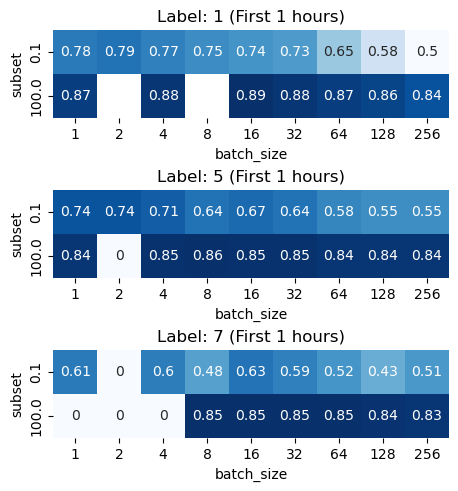

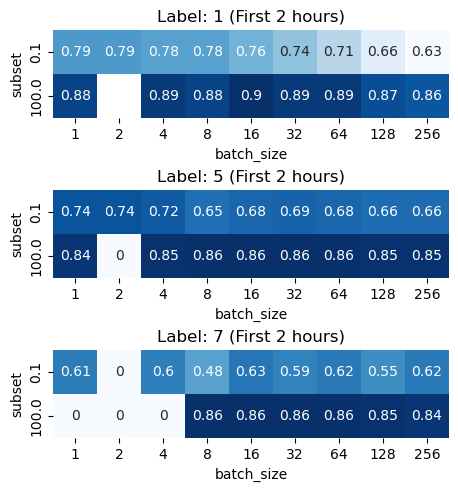

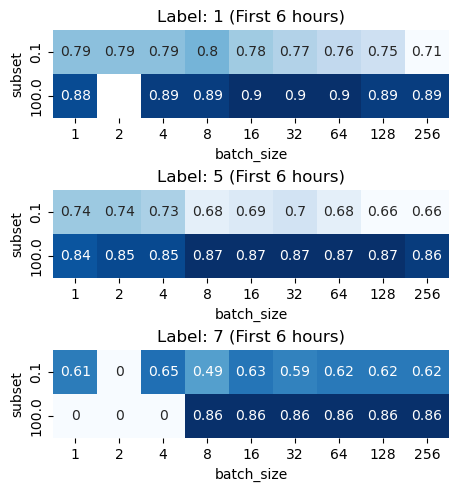

In [8]:
# for label 1
# which (subset, batch_size pairs have been tried, and what was their maximum val dice score?\
def do_plot_heatmap(df, thresh_time):
    fig, axs = plt.subplots(3, 1, squeeze=False, constrained_layout= True)
    for i, label in enumerate([1,5,7]):
        sub = df[df['label'] == label].copy()
        sub = sub[sub['_runtime'] <= thresh_time].reset_index(drop=True)
        xx = sub.groupby(['subset', 'batch_size']).agg('max').reset_index(drop=False)
        xx['val_dice_score'] = xx['val_dice_score'].round(decimals = 2)
        yy = xx[['subset', 'batch_size', 'val_dice_score']]

        pivoted = yy.pivot(index='subset', columns='batch_size', values='val_dice_score')



        sns.heatmap(pivoted, square=True, annot=True, cmap='Blues', cbar=False, ax = axs[i, 0])
        axs[i,0].set_title(f'Label: {label} (First {min(thresh_time//3600, 6)} hours)')

do_plot_heatmap(medsam_df, 3600)
do_plot_heatmap(medsam_df, 7200)
do_plot_heatmap(medsam_df, 1e9)
#do_plot_heatmap(unet_df, 3600)
#do_plot_heatmap(unet_df, 7200)
#do_plot_heatmap(unet_df, 1e9)

# label 7: 
# 0.1: batch size 8


In [41]:
paths_medsam = glob('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_retrain_dice_batchsz_expt_11-8-24/val/*/0.0005/*/*/eval_singletask_unprompted_val_label*.pkl')
paths_unet = glob('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_retrain_dice_batchsz_expt_11-11-24/val/0.0005/*/*/*/eval_singletask_unet_val_label*.pkl')

def do_work(paths, label_idx=-5):
    assemble = {'batch_size': [], 'frac': [], 'label': [], 'dice_sensitivity': [], 'dice_specificity': [], 'overall_dice': []}
    for p in paths:
        batch_size = int(p.split('/')[-2])
        frac = float(p.split('/')[-3])
        label = int(p.split('/')[label_idx])

        assemble['batch_size'].append(batch_size)
        assemble['frac'].append(frac)
        assemble['label'].append(label)

        dicto = pd.read_pickle(p)
        assemble['dice_sensitivity'].append(dicto['dice_sensitivity'].item())
        assemble['dice_specificity'].append(dicto['dice_specificity'].item())
        assemble['overall_dice'].append(dicto['overall_dice'].item())


    df = pd.DataFrame(assemble)


    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
    for i, frac in enumerate([0.1, 100]):
        for j, label in enumerate([1,5,7]):

            sub1 = df[(df['label'] == label) & (df['frac'] == frac)].reset_index(drop=True)
            melted = pd.melt(sub1, id_vars = ['label', 'frac', 'batch_size'], value_vars = ['dice_sensitivity', 'dice_specificity', 'overall_dice'])

            sns.lineplot(melted, x = 'batch_size', y = 'value', hue = 'variable', errorbar = None, marker='o', ax = axs[i,j])
            plt.xscale('log')
            axs[i,j].get_legend().remove()
            axs[i,j].title.set_text(f'Label {label}, frac {frac}')
    #plt.figlegend(loc='lower right',bbox_to_anchor=(0.85,0.25))
   

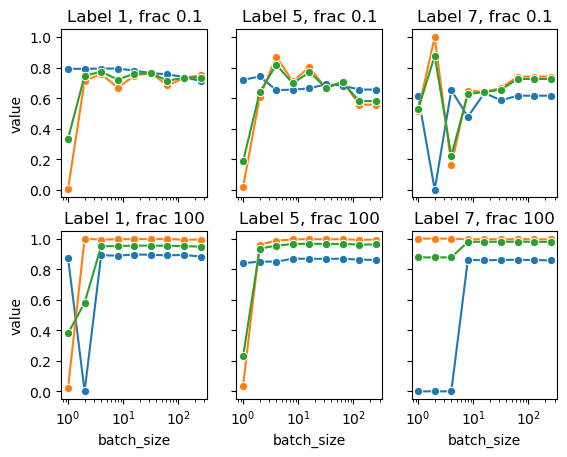

In [39]:
do_work(paths_medsam)

In [45]:
pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_retrain_dice_batchsz_expt_11-11-24/val/0.0005/1/0.1/256/eval_singletask_unet_val_label1.pkl')

{'dice_sensitivity': tensor([0.7837]),
 'dice_specificity': tensor([0.8373]),
 'overall_dice': tensor([0.8148]),
 'label_numbers': []}

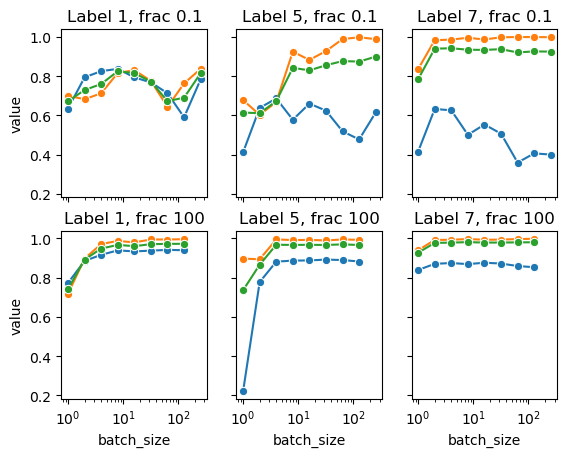

In [42]:
do_work(paths_unet, label_idx=-4)